In [1]:
import torch
import torch.nn.functional as F
import os
import os.path
import shutil
import numpy as np
import soundfile as sf
import librosa as lr
import librosa.display as lrd
import matplotlib.pyplot as plt

from pathlib import PurePath
from torch import nn
from torch.utils.data import DataLoader, random_split
from asteroid.data import TimitDataset
from asteroid.data.utils import CachedWavSet, RandomMixtureSet, FixedMixtureSet
from asteroid_filterbanks.transforms import mag
from tqdm import tqdm
from einops import rearrange

from torch import optim
from pytorch_lightning import Trainer, seed_everything, loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from asteroid_filterbanks import make_enc_dec
from asteroid_filterbanks.transforms import mag
from asteroid.engine import System, UNetGAN
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_mse

from asteroid import DCUNet, DCCRNet, DPRNNTasNet, ConvTasNet, RegressionFCNN, WaveUNet, Demucs

%load_ext autoreload
%autoreload 2

## Constants and utils

In [16]:
BATCH_SIZE       = 32     # could be more on cluster, test if larger one work
SAMPLE_RATE      = 8000   # as agreed upon
CROP_LEN         = 24000  # average track len in TIMIT
SEED             = 42     # magic number :)    

# directory with train noises (n116-n120)
DRONE_NOISE_DIR = '../../../datasets/noises-train-drones'
# fixed SNRs for validation set
TRAIN_SNRS = [-25, -20, -15, -10, -5]

def sisdr_loss_wrapper(est_target, target):
    return singlesrc_neg_sisdr(est_target.squeeze(1), target).mean()

def train_val_split(ds, val_fraction=0.1, random_seed=SEED):
    assert val_fraction > 0 and val_fraction < 0.5
    len_train = int(len(ds) * (1 - val_fraction))
    len_val = len(ds) - len_train
    return random_split(ds, [len_train, len_val], generator=torch.Generator().manual_seed(random_seed))

def get_opt_and_sched(model, lr, lr_patience):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=lr_patience)
    return optimizer, scheduler

## Prepare the data

### Download and resample TIMIT dataset 

In [8]:
TIMIT_DIR = PurePath('../../../datasets/TIMIT')
TIMIT_DIR_8kHZ = PurePath('../../../datasets/TIMIT_8kHZ')

In [28]:
TimitDataset.download(TIMIT_DIR)

Dataset seems to be already downloaded and extracted


In [9]:
os.makedirs(TIMIT_DIR_8kHZ, exist_ok=True)
shutil.copyfile(TIMIT_DIR / 'train_data.csv', TIMIT_DIR_8kHZ / 'train_data.csv')
shutil.copyfile(TIMIT_DIR / 'test_data.csv', TIMIT_DIR_8kHZ / 'test_data.csv')

data_dir_in = TIMIT_DIR / 'data'
data_dir_out = TIMIT_DIR_8kHZ / 'data'

def resample(ds, dir_in, dir_out, message='Resampling'):
    dl = DataLoader(ds, num_workers=10)
    for wav, path in tqdm(dl, message):
        path = PurePath(path[0])
        out_path = dir_out / path.relative_to(dir_in)
        os.makedirs(out_path.parent, exist_ok=True)
        sf.write(file=out_path, data=wav[0].numpy(), samplerate=SAMPLE_RATE)

timit_train = TimitDataset(TIMIT_DIR, subset='train', sample_rate=SAMPLE_RATE)
resample(timit_train, data_dir_in, data_dir_out, 'Resampling training data')

timit_test = TimitDataset(TIMIT_DIR, subset='test', sample_rate=SAMPLE_RATE)
resample(timit_test, data_dir_in, data_dir_out, 'Resampling test data')

Resampling test data: 100%|██████████| 1680/1680 [01:59<00:00, 14.09it/s]


In [17]:
demucs = Demucs()
CROP_LEN = demucs.wavenet.valid_length(CROP_LEN)
CROP_LEN

24149

### Load and split the data

In [18]:
# This is for training with on-the-fly random noise mixture with random SNR from the range.
# Is expected to produce a more robust result: checking this now on EECS server

# Reproducibility - fix all random seeds
seed_everything(SEED)

# Load noises, resample and save into the memory
noises = CachedWavSet(DRONE_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

# Load clean data and split it into train and val
timit = TimitDataset(TIMIT_DIR_8kHZ, subset='train', sample_rate=SAMPLE_RATE, with_path=False)
timit_train, timit_val = train_val_split(timit, val_fraction=0.1, random_seed=SEED)

# Training data mixes crops randomly on the fly with random SNR in range (effectively infinite training data)
# `repeat_factor=20` means that the dataset contains 20 copies of itself - it is the easiest way to make the epoch longer
timit_train = RandomMixtureSet(timit_train, noises, random_seed=SEED, snr_range=(-25, -5),
                               crop_length=CROP_LEN, repeat_factor=10)

# Validation data is fixed (for stability): mix every clean clip with all the noises in the folder
# Argument `mixtures_per_clean` regulates with how many different noise files each clean file will be mixed
timit_val = FixedMixtureSet(timit_val, noises, snrs=TRAIN_SNRS, random_seed=SEED,
                            mixtures_per_clean=5, crop_length=CROP_LEN)

Global seed set to 42
Precaching audio: 100%|██████████| 5/5 [00:29<00:00,  5.97s/it]


In [19]:
# Reproducibility - fix all random seeds
# seed_everything(SEED)

# # Load noises, resample and save into the memory
# noises = CachedWavSet(DRONE_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

# timit = TimitDataset(TIMIT_DIR_8kHZ, subset='train', sample_rate=SAMPLE_RATE, with_path=False)
# timit_mix = FixedMixtureSet(timit, noises, snrs=TRAIN_SNRS, random_seed=SEED,
#                             mixtures_per_clean=5, crop_length=CROP_LEN)

# timit_train, timit_val = train_val_split(timit_mix, val_fraction=0.1, random_seed=SEED)

In [21]:
NUM_WORKERS = 5
train_loader = DataLoader(timit_train, shuffle=True, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS, drop_last=True)
val_loader = DataLoader(timit_val, batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS, drop_last=True)

In [25]:
optimizer, scheduler = get_opt_and_sched(demucs, LR, REDUCE_LR_PATIENCE)
system = System(demucs, optimizer, F.l1_loss, train_loader, val_loader, scheduler)

In [26]:
LOG_DIR = '../../../workspace/logs'
logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='TIMIT-drones-Demucs-dummy', version=1)

trainer = Trainer(max_epochs=10, logger=logger, deterministic=True, fast_dev_run=True)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).


In [27]:
trainer.fit(system)


  | Name  | Type   | Params
---------------------------------
0 | model | Demucs | 18.9 M
---------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.472    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/data/home/acw592/projects/asteroid/asteroid/engine/system.py:101: UserWarning: Using a target size (torch.Size([32, 24149])) that is different to the input size (torch.Size([32, 1, 24149])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.loss_func(est_targets, targets)


Validating: 0it [00:00, ?it/s]

1

In [8]:
baseline_model = RegressionFCNN()
baseline_model.compute_scaler(train_loader)

Computing scaler: 100%|██████████| 3248/3248 [14:39<00:00,  3.69it/s] 


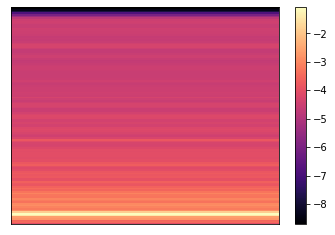

In [9]:
mean = baseline_model.scaler_mean
long = torch.stack([mean]*100).T
img = lrd.specshow(long.numpy())
plt.colorbar(img)

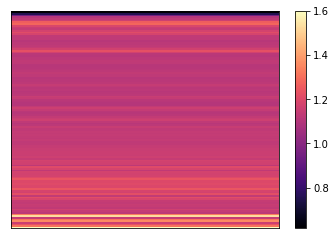

In [10]:
std = baseline_model.scaler_std
long = torch.stack([std]*100).T
img = lrd.specshow(long.numpy())
plt.colorbar(img)

## Baseline model training

In [24]:
# some random parameters, does it look sensible?
LR = 1e-4
REDUCE_LR_PATIENCE = 3
EARLY_STOP_PATIENCE = 10
MAX_EPOCHS = 300

In [12]:
def _unsqueeze_to_3d(x):
    """Normalize shape of `x` to [batch, n_chan, time]."""
    if x.ndim == 1:
        return x.reshape(1, 1, -1)
    elif x.ndim == 2:
        return x.unsqueeze(1)
    else:
        return x

class MagnitudeIRMSystem(System):
    def common_step(self, batch, batch_nb, train=True):
        mix, clean = batch
        mix = _unsqueeze_to_3d(mix)
        clean = _unsqueeze_to_3d(clean)
        
        mix_tf = self.model.forward_encoder(mix)
        clean_tf = self.model.forward_encoder(clean)
        
        true_irm = torch.minimum(mag(clean_tf) / mag(mix_tf), torch.tensor(1).type_as(mix_tf))
        est_irm = self.model.forward_masker(mix_tf)
        loss = self.loss_func(est_irm, true_irm)
        return loss

In [13]:
optimizer, scheduler = get_opt_and_sched(baseline_model, LR, REDUCE_LR_PATIENCE)
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)
checkpoint = ModelCheckpoint(
    filename='{epoch:02d}-{val_loss:.2f}',
    monitor="val_loss",
    mode="min",
    save_top_k=5,
    verbose=True
)

system = MagnitudeIRMSystem(baseline_model, optimizer, F.mse_loss, train_loader, val_loader, scheduler)

In [14]:
logger = pl_loggers.TensorBoardLogger('logs', name='TIMIT-drones-baseline-proper', version=1)

# choose the proper accelerator for JADE, probably `ddp` (also, `auto_select_gpus=True` might be useful)
trainer = Trainer(max_epochs=MAX_EPOCHS, gpus=-1, accelerator='dp',
                  logger=logger, callbacks=[early_stopping, checkpoint], deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [15]:
trainer.fit(system)


  | Name  | Type           | Params
-----------------------------------------
0 | model | RegressionFCNN | 10.5 M
-----------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params


/homes/dm005/conda_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch 0, global step 3247: val_loss reached 0.03913 (best 0.03913), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=00-val_loss=0.04.ckpt" as top 5


Epoch 1, global step 6495: val_loss reached 0.03398 (best 0.03398), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=01-val_loss=0.03.ckpt" as top 5


Epoch 2, global step 9743: val_loss reached 0.03181 (best 0.03181), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=02-val_loss=0.03.ckpt" as top 5


Epoch 3, global step 12991: val_loss reached 0.03083 (best 0.03083), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=03-val_loss=0.03.ckpt" as top 5


Epoch 4, global step 16239: val_loss reached 0.03044 (best 0.03044), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=04-val_loss=0.03.ckpt" as top 5


Epoch 5, global step 19487: val_loss reached 0.02957 (best 0.02957), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=05-val_loss=0.03.ckpt" as top 5


Epoch 6, global step 22735: val_loss reached 0.02878 (best 0.02878), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=06-val_loss=0.03.ckpt" as top 5


Epoch 7, global step 25983: val_loss reached 0.02883 (best 0.02878), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=07-val_loss=0.03.ckpt" as top 5


Epoch 8, global step 29231: val_loss reached 0.02818 (best 0.02818), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=08-val_loss=0.03.ckpt" as top 5


Epoch 9, global step 32479: val_loss reached 0.02838 (best 0.02818), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=09-val_loss=0.03.ckpt" as top 5


Epoch 10, global step 35727: val_loss reached 0.02827 (best 0.02818), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=10-val_loss=0.03.ckpt" as top 5


Epoch 11, global step 38975: val_loss reached 0.02814 (best 0.02814), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=11-val_loss=0.03.ckpt" as top 5


Epoch 12, global step 42223: val_loss reached 0.02813 (best 0.02813), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=12-val_loss=0.03.ckpt" as top 5


Epoch 13, global step 45471: val_loss reached 0.02724 (best 0.02724), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=13-val_loss=0.03.ckpt" as top 5


Epoch 14, global step 48719: val_loss reached 0.02777 (best 0.02724), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=14-val_loss=0.03.ckpt" as top 5


Epoch 15, global step 51967: val_loss reached 0.02776 (best 0.02724), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=15-val_loss=0.03.ckpt" as top 5


Epoch 16, global step 55215: val_loss reached 0.02768 (best 0.02724), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=16-val_loss=0.03.ckpt" as top 5


Epoch 17, global step 58463: val_loss reached 0.02769 (best 0.02724), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=17-val_loss=0.03.ckpt" as top 5


Epoch 18, global step 61711: val_loss reached 0.02688 (best 0.02688), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=18-val_loss=0.03.ckpt" as top 5


Epoch 19, global step 64959: val_loss reached 0.02708 (best 0.02688), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=19-val_loss=0.03.ckpt" as top 5


Epoch 20, global step 68207: val_loss reached 0.02672 (best 0.02672), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=20-val_loss=0.03.ckpt" as top 5


Epoch 21, global step 71455: val_loss reached 0.02702 (best 0.02672), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=21-val_loss=0.03.ckpt" as top 5


Epoch 22, global step 74703: val_loss reached 0.02661 (best 0.02661), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=22-val_loss=0.03.ckpt" as top 5


Epoch 23, global step 77951: val_loss reached 0.02681 (best 0.02661), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=23-val_loss=0.03.ckpt" as top 5


Epoch 24, global step 81199: val_loss reached 0.02647 (best 0.02647), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=24-val_loss=0.03.ckpt" as top 5


Epoch 25, global step 84447: val_loss reached 0.02658 (best 0.02647), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=25-val_loss=0.03.ckpt" as top 5


Epoch 26, global step 87695: val_loss reached 0.02659 (best 0.02647), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=26-val_loss=0.03.ckpt" as top 5


Epoch 27, global step 90943: val_loss reached 0.02665 (best 0.02647), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=27-val_loss=0.03.ckpt" as top 5


Epoch 28, step 94191: val_loss was not in top 5


Epoch 29, global step 97439: val_loss reached 0.02664 (best 0.02647), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=29-val_loss=0.03.ckpt" as top 5


Epoch 30, step 100687: val_loss was not in top 5


Epoch 31, step 103935: val_loss was not in top 5


Epoch 32, global step 107183: val_loss reached 0.02657 (best 0.02647), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=32-val_loss=0.03.ckpt" as top 5


Epoch 33, global step 110431: val_loss reached 0.02653 (best 0.02647), saving model to "logs/TIMIT-drones-baseline-proper/version_1/checkpoints/epoch=33-val_loss=0.03.ckpt" as top 5


Epoch 34, step 113679: val_loss was not in top 5


1

In [16]:
torch.save(baseline_model.serialize(), '../../../workspace/models/baseline_model_fixed_mse.pt')

## Set up the model, optimizer and scheduler

In [17]:
LR = 1e-4
REDUCE_LR_PATIENCE = 3
EARLY_STOP_PATIENCE = 10
MAX_EPOCHS = 300

# the model here should be constructed in the script accordingly to the passed config (including the model type)
# most of the models accept `sample_rate` parameter for encoders, which is important (default is 16000, override)
#model = DCUNet("DCUNet-20", fix_length_mode="trim", sample_rate=SAMPLE_RATE)
#model = DCCRNet("DCCRN-CL", sample_rate=SAMPLE_RATE)
model = WaveUNet()
loss = F.mse_loss

# Glorot initialization of the model's parameters (important, mentioned in the paper)
# lrelu_gain = nn.init.calculate_gain('leaky_relu', 0.01)
# def init_weights(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.xavier_normal_(m.weight, gain=lrelu_gain)
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)
    
# model = model.apply(init_weights)

In [18]:
optimizer, scheduler = get_opt_and_sched(model, LR, REDUCE_LR_PATIENCE)
early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)
checkpoint = ModelCheckpoint(
    filename='{epoch:02d}-{val_loss:.2f}',
    monitor="val_loss",
    mode="min",
    save_top_k=5,
    verbose=True
)

# Probably we also need to subclass `System`, in order to log the target metrics on the validation set (PESQ/STOI)
system = System(model, optimizer, loss, train_loader, val_loader, scheduler)

In [19]:
# log dir and model name are also part of the config, of course
LOG_DIR = 'logs'
logger = pl_loggers.TensorBoardLogger(LOG_DIR, name='TIMIT-drones-WaveUNet-proper', version=1)

# choose the proper accelerator for JADE, probably `ddp` (also, `auto_select_gpus=True` might be useful)
trainer = Trainer(max_epochs=MAX_EPOCHS, gpus=-1, accelerator='dp',
                  logger=logger, callbacks=[early_stopping, checkpoint], deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


## Train

In [ ]:
trainer.fit(system)


  | Name  | Type     | Params
-----------------------------------
0 | model | WaveUNet | 3.3 M 
-----------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params


/homes/dm005/projects/asteroid/asteroid/engine/system.py:113: UserWarning: Using a target size (torch.Size([8, 24000])) that is different to the input size (torch.Size([8, 1, 24000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.loss_func(est_targets, targets)


Epoch 0, global step 3247: val_loss reached 0.00029 (best 0.00029), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=00-val_loss=0.00.ckpt" as top 5


Epoch 1, global step 6495: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=01-val_loss=0.00.ckpt" as top 5


Epoch 2, global step 9743: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=02-val_loss=0.00.ckpt" as top 5


Epoch 3, global step 12991: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=03-val_loss=0.00.ckpt" as top 5


Epoch 4, global step 16239: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=04-val_loss=0.00.ckpt" as top 5


Epoch 5, global step 19487: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=05-val_loss=0.00.ckpt" as top 5


Epoch 6, global step 22735: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=06-val_loss=0.00.ckpt" as top 5


Epoch 7, global step 25983: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=07-val_loss=0.00.ckpt" as top 5


Epoch 8, global step 29231: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=08-val_loss=0.00.ckpt" as top 5


Epoch 9, global step 32479: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=09-val_loss=0.00.ckpt" as top 5


Epoch 10, global step 35727: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=10-val_loss=0.00.ckpt" as top 5


Epoch 11, global step 38975: val_loss reached 0.00028 (best 0.00028), saving model to "logs/TIMIT-drones-WaveUNet-proper/version_1/checkpoints/epoch=11-val_loss=0.00.ckpt" as top 5


In [ ]:
torch.save(model.serialize(), '../../../workspace/models/waveunet_fixed_mse.pt')

## Save the models fully with all the parameters

In [12]:
torch.save(model.serialize(), 'dccrn_random_v1.pt')